# Pauli Twirling Simulation
Source: https://docs.quantum.ibm.com/transpile/custom-transpiler-pass

In [1]:
from qiskit.dagcircuit import DAGCircuit
from qiskit.circuit import QuantumCircuit, QuantumRegister, Gate
from qiskit.circuit.library import CXGate, ECRGate
from qiskit.transpiler import PassManager
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.quantum_info import Operator, pauli_basis
from qiskit import qasm2
 
import numpy as np
 
from typing import Iterable, Optional

import matplotlib

In [2]:
class PauliTwirl(TransformationPass):
    """Add Pauli twirls to two-qubit gates."""
 
    def __init__(
        self,
        gates_to_twirl: Optional[Iterable[Gate]] = None,
    ):
        """
        Args:
            gates_to_twirl: Names of gates to twirl. The default behavior is to twirl all
                two-qubit basis gates, `cx` and `ecr` for IBM backends.
        """
        if gates_to_twirl is None:
            gates_to_twirl = [CXGate(), ECRGate()]
        self.gates_to_twirl = gates_to_twirl
        self.build_twirl_set()
        super().__init__()
 
    def build_twirl_set(self):
        """
        Build a set of Paulis to twirl for each gate and store internally as .twirl_set.
        """
        self.twirl_set = {}
 
        # iterate through gates to be twirled
        for twirl_gate in self.gates_to_twirl:
            twirl_list = []
 
            # iterate through Paulis on left of gate to twirl
            for pauli_left in pauli_basis(2):
 
                # iterature through Paulis on right of gate to twirl
                for pauli_right in pauli_basis(2):
 
                    # save pairs that produce identical operation as gate to twirl
                    if (Operator(pauli_left) @ Operator(twirl_gate)).equiv(Operator(twirl_gate) @ pauli_right):
                        twirl_list.append((pauli_left, pauli_right))
 
            self.twirl_set[twirl_gate.name] = twirl_list
 
    def run(
        self,
        dag: DAGCircuit,
    ) -> DAGCircuit:
 
        # collect all nodes in DAG and proceed if it is to be twirled
        twirling_gate_classes = tuple(gate.base_class for gate in self.gates_to_twirl)
        for node in dag.op_nodes():
            if not isinstance(node.op, twirling_gate_classes):
                continue
 
            # random integer to select Pauli twirl pair
            pidx = np.random.randint(0, len(self.twirl_set[node.op.name]),)
            twirl_pair = self.twirl_set[node.op.name][pidx]
 
            # instantiate mini_dag and attach quantum register
            mini_dag = DAGCircuit()
            register = QuantumRegister(2)
            mini_dag.add_qreg(register)
 
            # apply left Pauli, gate to twirl, and right Pauli to empty mini-DAG
            mini_dag.apply_operation_back(twirl_pair[0].to_instruction(), [register[0], register[1]])
            mini_dag.apply_operation_back(node.op, [register[0], register[1]])
            mini_dag.apply_operation_back(twirl_pair[1].to_instruction(), [register[0], register[1]])
 
            # substitute gate to twirl node with twirling mini-DAG
            dag.substitute_node_with_dag(node, mini_dag)
 
        return dag

In [3]:
# create quantum circuit
qc = QuantumCircuit(3)
qc.cx(0, 1)
qc.ecr(1, 2)
qc.ecr(1, 0)
qc.cx(2, 1)
qc.draw()

┌──────┐     
q_0: ──■──────────┤1     ├─────
     ┌─┴─┐┌──────┐│  Ecr │┌───┐
q_1: ┤ X ├┤0     ├┤0     ├┤ X ├
     └───┘│  Ecr │└──────┘└─┬─┘
q_2: ─────┤1     ├──────────■──
          └──────┘

In [4]:
pm = PassManager([PauliTwirl()])
twirled_qcs = [pm.run(qc) for _ in range(50)]

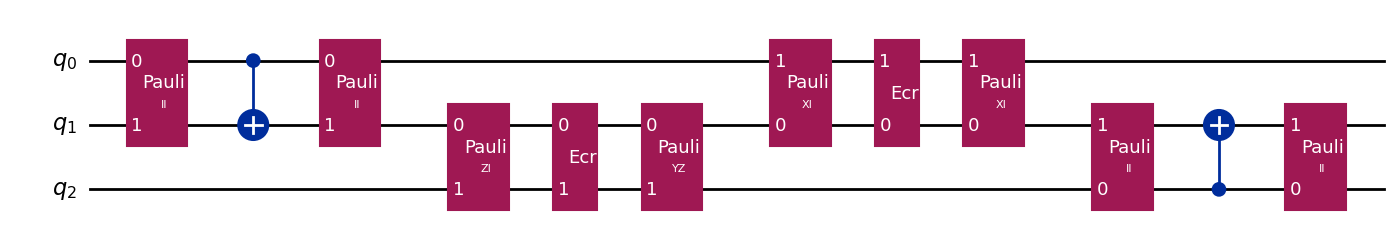

In [5]:
twirled_qcs[-1].draw(output='mpl')

In [6]:
s = qasm2.dumps(twirled_qcs[-1]).replace("param0", "").replace("rzx()", "rzx(param0)").replace("rz()", "rz(param0)")
s = s.replace("[XYIZ]+", "")

In [63]:
p

In [7]:
circuit = QuantumCircuit.from_qasm_str(s)
circuit.draw(output='mpl')

QASM2ParseError: "<input>:11,6: identifiers cannot start with capital letters except for the builtins 'U' and 'CX'"